In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.constants as cs
import os
import astropy.io.fits as pyfits

import hstscan.pipeline as pipe
import hstscan.reduction as r
import hstscan.data as data
from hstscan.data import view_frame_image as view
import tqdm
import glob

# Setup for light-curve reduction

### 1) Download data
https://archive.stsci.edu/hst/search.php

\_ima files for all data

\_drz and \_flt files for the direct images (taken with Filters instead of Grism)

Get HST ephemeris data at https://ssd.jpl.nasa.gov/horizons.cgi?s_tset=1#top

In [2]:
# data_dir: directory where the _ima files are stored
data_dir = '/Users/bob/Documents/PhD/hstscan/hstscan/example/Data/'
output_dir = '/Users/bob/Documents/PhD/hstscan/hstscan/example/output/'

conf_file_red = '/Users/bob/Documents/PhD/hstscan/hstscan/example/transmission_reduction.conf'
conf_file_ext = '/Users/bob/Documents/PhD/hstscan/hstscan/example/transmission_extraction.conf'

### 2) Produce visit information lists

In [3]:
# prop_str: first 4 characters of the files' names (proposal ID string)
data.make_input_image_lists(data_dir=data_dir, prop_str='ibh7', conf_file = conf_file_red)

['26']
Starting visit 26
ibh726meq_ima.fits
Completed file 1 for visit 26
ibh726mdq_ima.fits
Completed file 2 for visit 26
ibh726miq_ima.fits
Completed file 3 for visit 26
#####################
Visit 26 completed.
#####################


At this point it makes sense to re-name the visit files to more appropriate names, e.g. visit_26.lis -> transit.lis

### 3) Define a list of reference files

These reference files are used to calculate the absolute wavelength solution. They are typically the first grism exposures of each visit. Each visit should have at least one reference exposure.

In [4]:
ref_Images = ['ibh726meq_ima.fits']

### 2) Fit direct image positions to produce position catalogues

Writing to: /Users/bob/Documents/PhD/hstscan/hstscan/example/Data/ibh726mdq_flt_1.cat
Shape (242, 271)


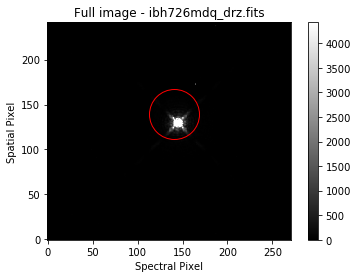

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude  5.125e+05        0      inf     1693     True     None     None
x_mean        25.03        0       60  0.00366     True     None     None
x_stddev      1.107        0      inf 0.003654     True     None     None
y_mean        9.206        0       60 0.003578     True     None     None
y_stddev      1.082        0      inf 0.003575     True     None     None


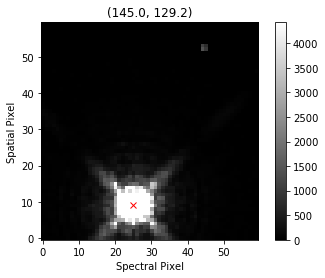

In [5]:
# gridsize: coarseness of initial search for source
# nstars: number of stars for which positions should be measured (in order of brightness)
# use_ima: use _ima files instead of _flt in case of problems
pipe.create_orbit_cats_gauss(data_dir=data_dir, conf_file=conf_file_red, gridsize=20, use_ima=False, nstars=1)

Now have everything you need to reduce an exposure and produce spectra

# Config file parameters

## Red

### Parameters to define yourself
 - source_dir
 - save_dir
 - scan_rate
 - bg_x,y,w,h
 - flat_file_g141
 - conf_file_g141
 - ref_exp
 - stellar_spectrum (PHOENIX model. TBF @ http://phoenix.astro.physik.uni-goettingen.de/?page_id=16) from https://arxiv.org/pdf/1303.5632.pdf
     You could also use a .txt file with one column of wavelengths in Angstrom and one of Flux in erg/s/cm^2/A. This file should have a one-line-header
 
### Leave
These you are unlikely to want to change, although their effects are important
 - scanned = True
 - units = True
 - read_noise = 20
 - skip_start = 1
 - skip_end = 0
 - bg = True
 - bg_area = True
 - cr_local = True
 - dispersion = True
 - flat_field = True
 - ff_min = 0.5
 - contam_thresh = 0.01
 - nysig = 5
 - calc_abs_xshift = True.   #Whether to calculate the wavelength solution from the grism transmission fct.
 
### Cosmic Rays
You may want to experiment with cosmic ray removal parameters, can turn off cosmic ray removal for a first run
 - cr_tol = 15 (try to lower without removing spectrum)
 - cr_x,y (consider tweaking if CR removal too agressive/weak)
 - cr_thresh = 50 (can raise)

### Data quality flags
Lookup flags in data handbook. 4: Bad detector pixel, 32: IR unstable pixel.

Leave as is unless there are problems.
 - dq_flags = [4,32]
 - dq_replace = None
 - dq_mean_width = 1
 
### Wavelength Solution
For now, disable the Tsiaras wavelength solution and use the simple interpolation.
May want to tweak drift_width and rowtol, parameters for smoothing the drift within an exposure.

E.g. define
 - exp_shift = False
 - tsiaras = False
 - exp_drift = True
 - drift_width = 4
 - drift_rowtol = 1.1


### Plots
Leave on while still tweaking
 - debug = True
 - pdf = True
 - logger = True
 - bg_plot = True
 - cr_plot = True
 
### Tweak to position extraction box
Depending on the observations, need to account/remove different effects to center the spectrum in the extraction box. Have not figured out a universal solution.

 - remove_scan
 - postarg_yguess
 - default_scan
 
 
### Ignore
These are either no longer used, in development, or were for specific data sets/modes.
 - system
 - nlincorr
 - psf_h (these are for bg removal with masks)
 - mask_h
 - psf_w
 - n_masks
 - neg_masks
 - cr_replace
 - cr_master
 - cr_mname
 - ref_exp
 - ref_wv0
 - ref_wv1
 - pre_shift_ff
 - peak
 - x_shift_ext
 - grid_y
 - grid_lam
 - two_scans 
 - interp_kind
 - object_ind

## Ext

### Parameters to define yourself
 - save_dir
 - box_h (ensure large enough to capture whole spectrum)
 - ref_exp
 
### Plots
- debug = True
- logger = True
- pdf = True
- oe_debug = False (its very slow, turn on only if focusing on optimal extraction)

### Leave
 - save_extension = '_spec.txt'
 - calc_var = True
 - extraction_box = True
 - shift_spectra = True
 - shift_wv0 = 1.14
 - shift_wv1 = 1.6
 - peak = False
 - opt_ext = True
 - exp_shift = True
 
### Optimal Extraction

#### Tweak
- fit_tol
- order
- step (only works if func_type is not spline, custom_spline or split_spline and method is lsq
- k_col/row

#### Leave
- s = 0
- v_0 = 400
- q = 1
- s_clip = None
- s_cosmic = None
- func_type = 'spline'
- method = 'lsq'
- remove_bg = True
- object_ind = 0
- fit_dq = True
 
### Ignore
- save_sub
- mask_neg
- ignore_blobx
- blob_thresh
- skip_fit
- top_half

# Run data reduction on one exposure

Check 

 - Do the subexposures agree, smoothly across the whole wavelength range?
 
 - How many optimal extraction fits fail near the peak of the spectrum?
 
 - Check the fits, are they overfitting or underfitting clearly? Safer to overfit.

sigma not a valid input to reduction, ignored.
CR 60 5.0
########################################
###########Starting Reduction###########
########################################
Data reduction pipeline performed on exposure /Users/bob/Documents/PhD/hstscan/hstscan/example/Data/ibh726meq_ima.fits
For configuration, see pipeline conf file: /Users/bob/Documents/PhD/hstscan/hstscan/example/transmission_reduction.conf


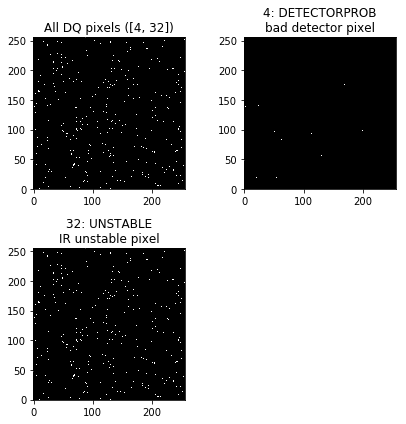

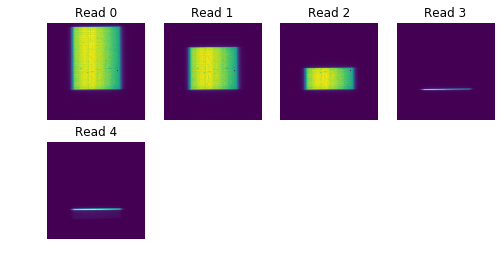

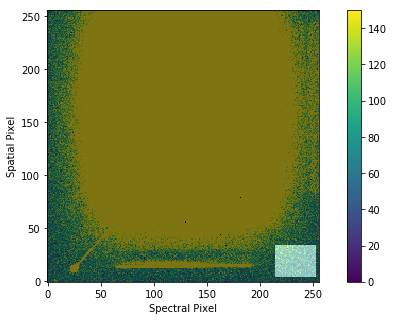

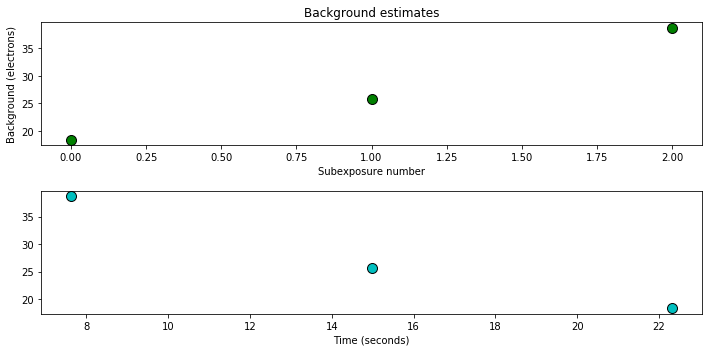

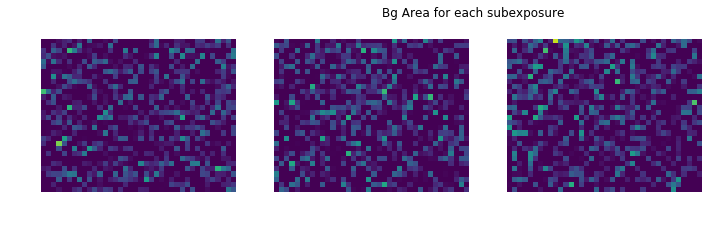

Forward scan
lrootname ibh726mdq
lrootname ibh726meq
Catalogue used: /Users/bob/Documents/PhD/hstscan/hstscan/example/Data/ibh726mdq_flt_1.cat
Direct Image name: ibh726mdq
Catalogue file: ibh726mdq_ima.fits
########################
Direct image location of (145.027019201,129.205912349)


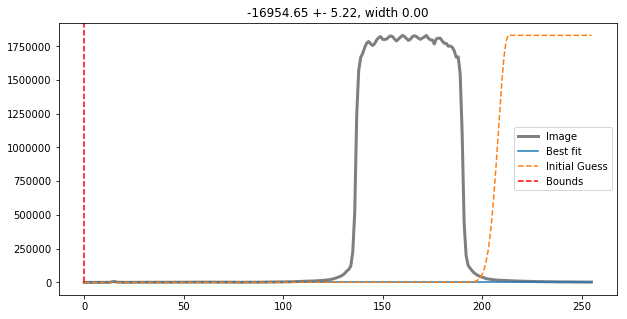

using a PHOENIX stellar model


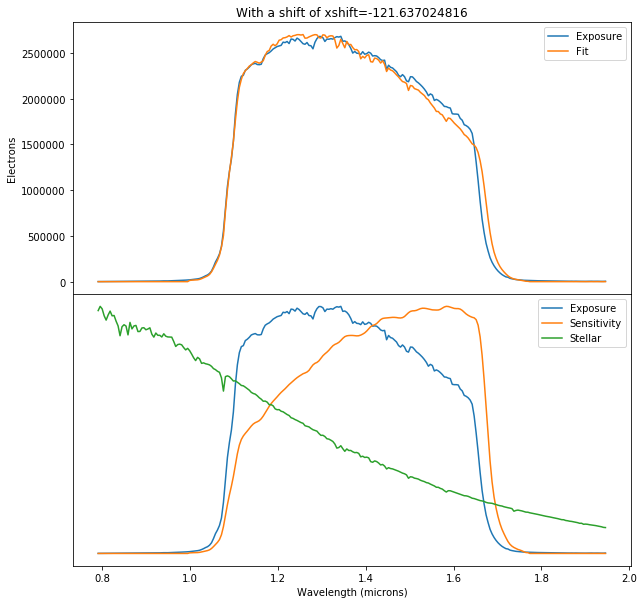

Applied an xshift of -121.637024816 pix compared to direct image
applying postarg offset to yguess, 147.60 pix


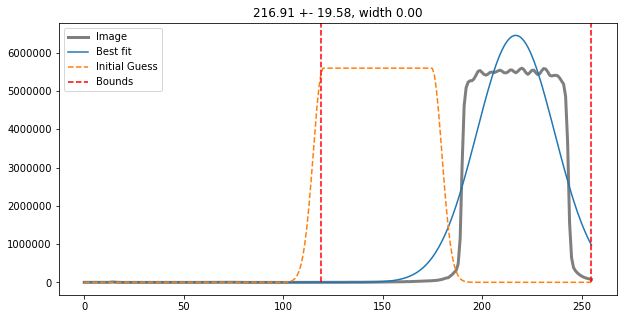

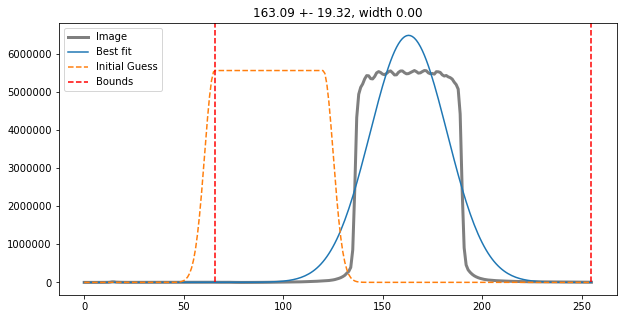

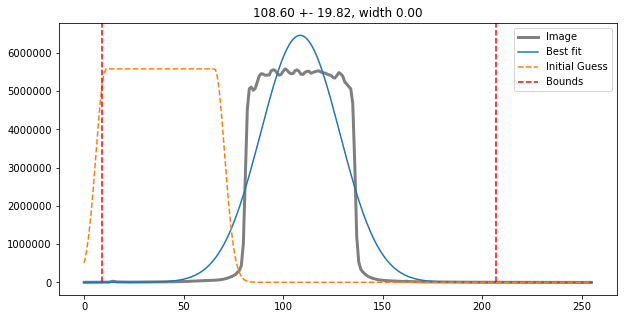

secondxpix 23.38999438478905 0.0
applying postarg offset to yguess, 147.60 pix


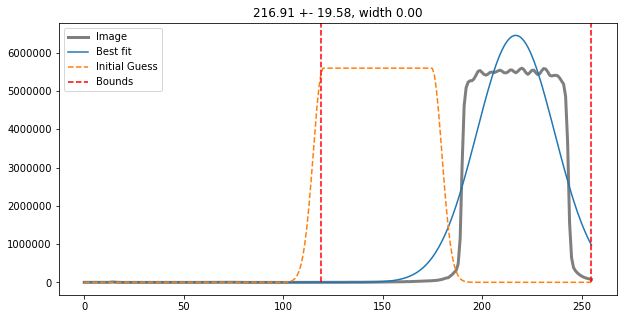

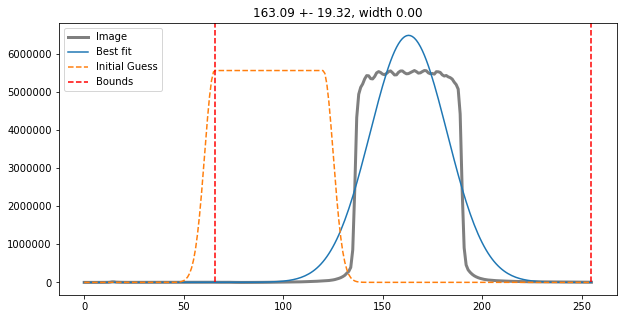

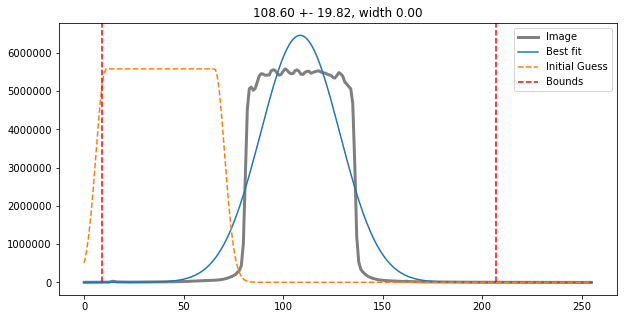

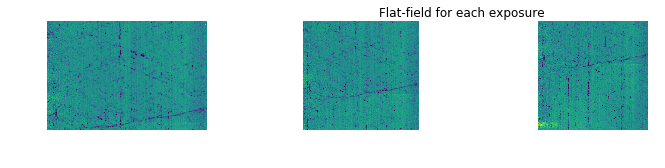

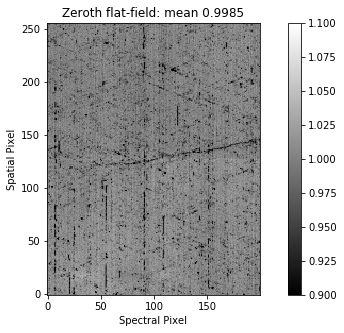

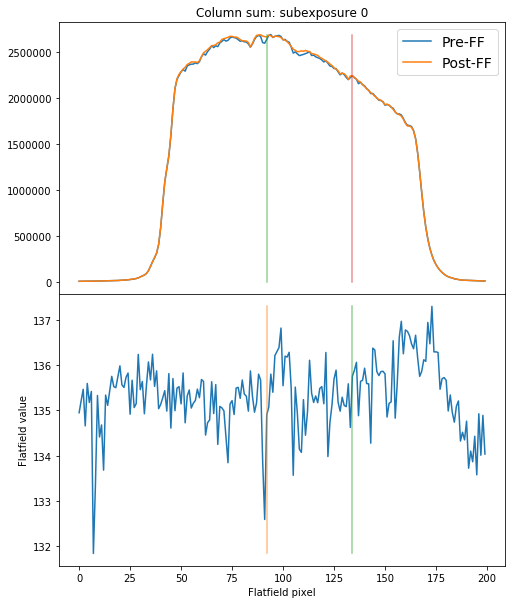

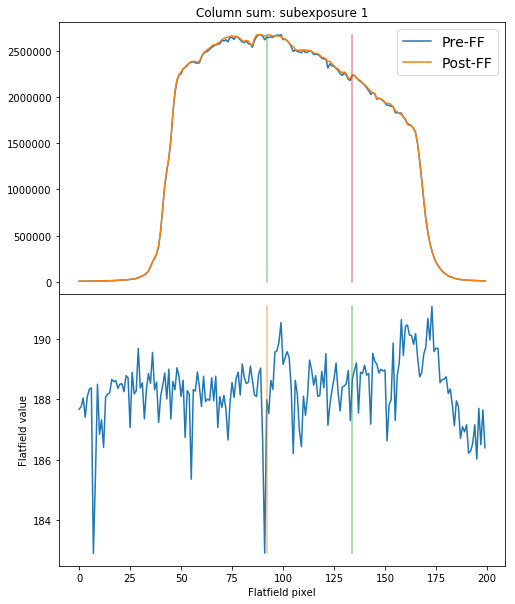

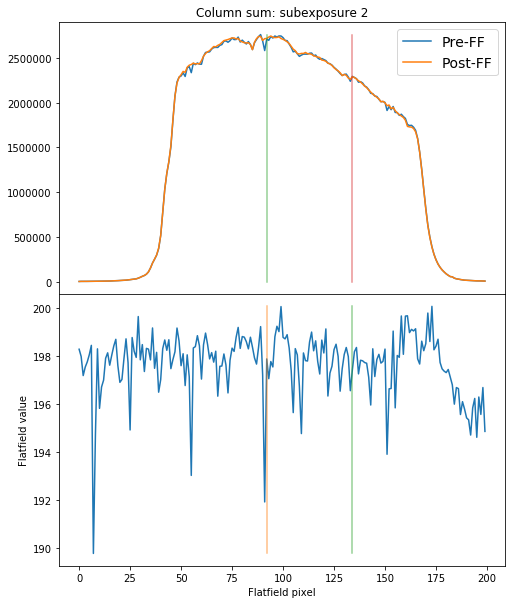

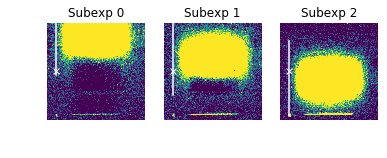

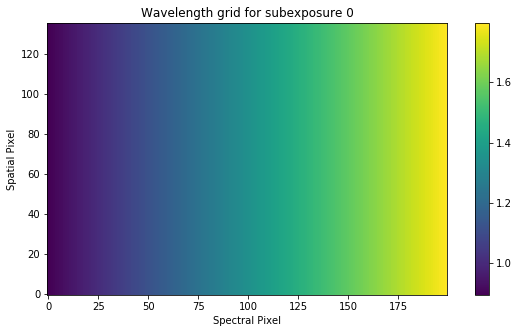

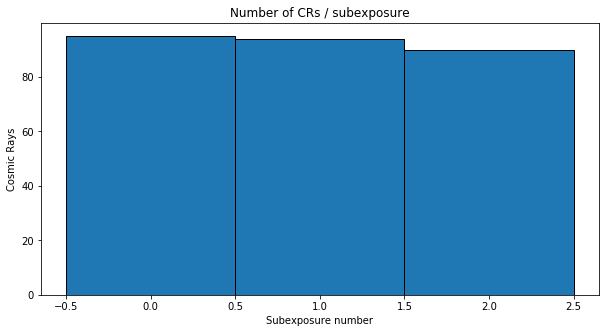

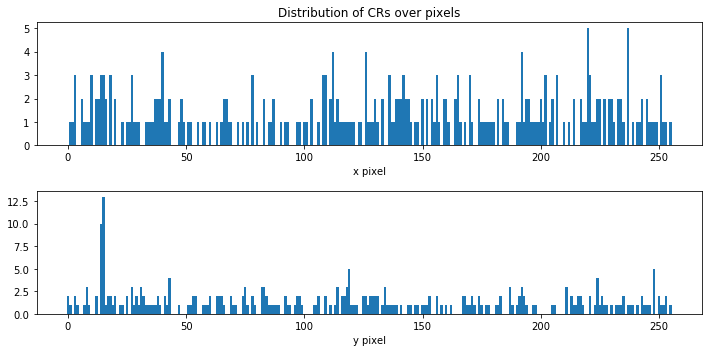

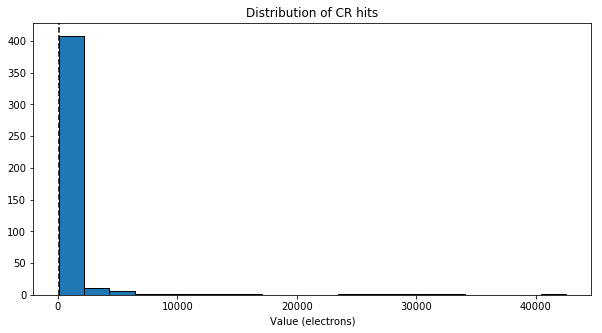

Nr. of DQs, CRs and CRs minus DQs 2388 279 269
Percentage of pixels affected by CRs: 0.41046142578125 %, which should be ~ 0.0867893833333 %


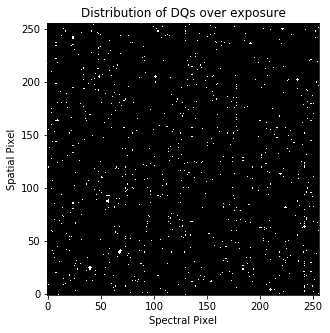

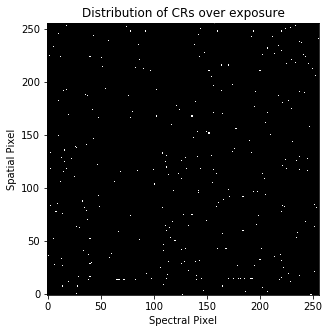

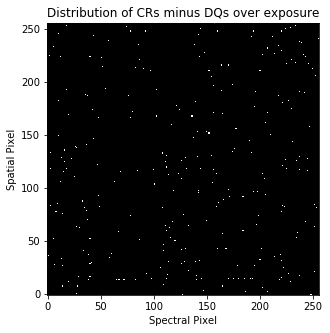

Saving reduced file to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/
Saving reduced exposure to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/ibh726meq_red.fits...
Reduction took 7.27s
########################################
###########Finished Reduction###########
########################################
########################################
###########Starting Extraction##########
########################################
Spectral extraction pipeline performed on exposure /Users/bob/Documents/PhD/hstscan/hstscan/example/Data/ibh726meq_ima.fits
For configuration, see conf file: /Users/bob/Documents/PhD/hstscan/hstscan/example/transmission_extraction.conf
Extracting from subexposure 1
Extracting spectrum with a 80 high extraction box
Spectrum located at pixel 123.389994385 in spatial direction
Using flux for variance estimate
Extracting spectrum with optimal extraction...


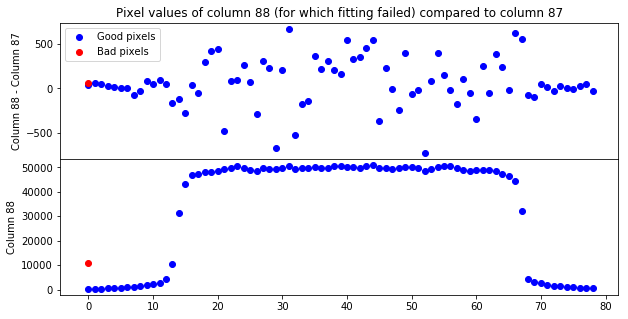

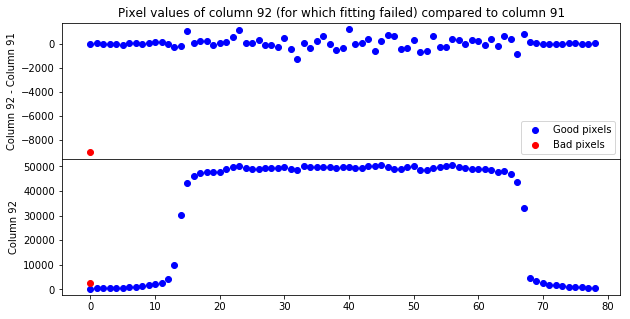

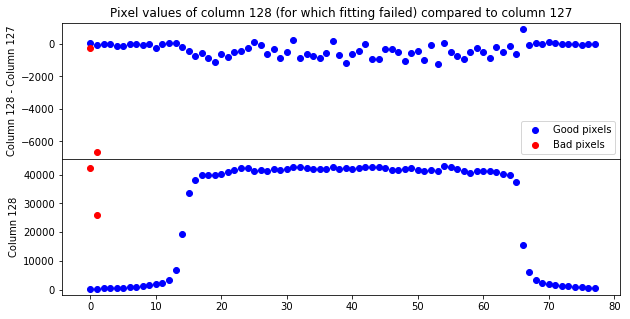

194 successes out of 200 total fits
Optimal extraction fitting failed for columns: [0, 1, 88, 92, 128, 198]
Clipped 0 cosmic rays in OE
Extracting from subexposure 2
Spectrum located at pixel 123.389994385 in spatial direction
Extracting spectrum with optimal extraction...


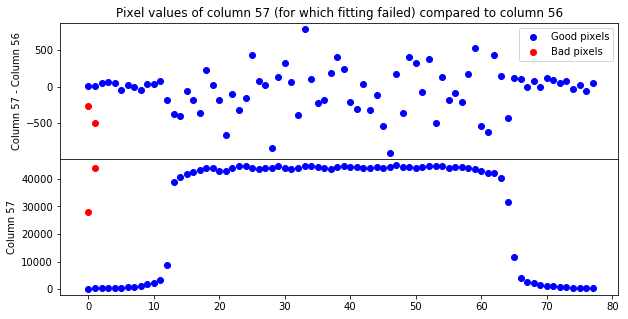

196 successes out of 200 total fits
Optimal extraction fitting failed for columns: [0, 1, 2, 57]
Clipped 0 cosmic rays in OE
Extracting from subexposure 3
Spectrum located at pixel 123.389994385 in spatial direction
Extracting spectrum with optimal extraction...


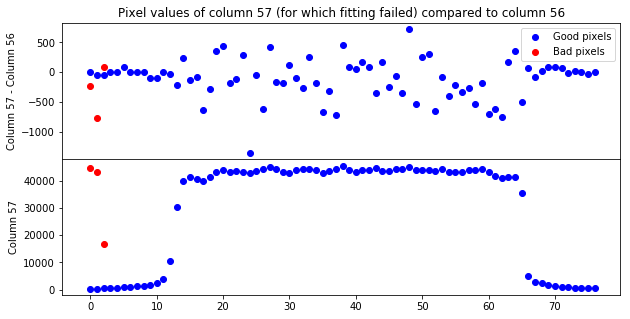

190 successes out of 200 total fits
Optimal extraction fitting failed for columns: [3, 5, 6, 7, 8, 57]
Clipped 0 cosmic rays in OE


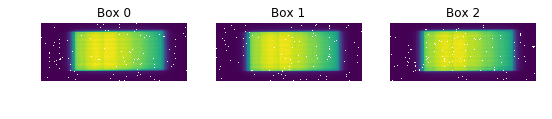

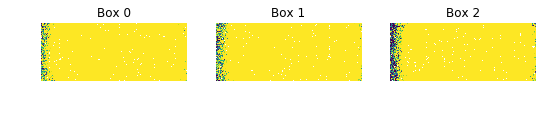

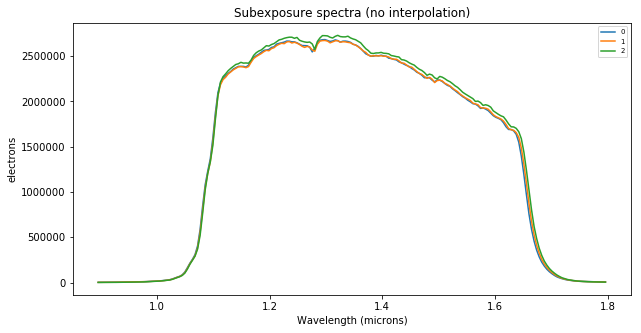

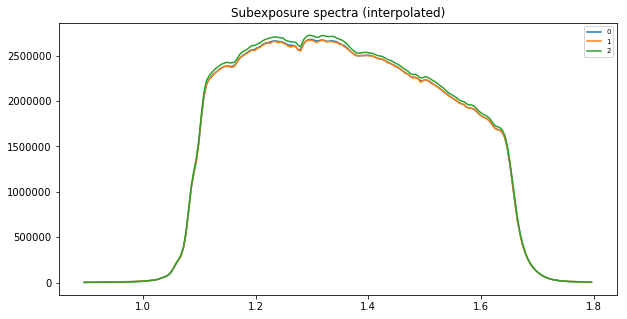

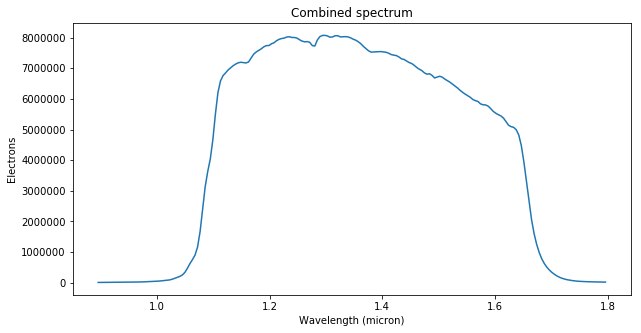

Saving spectrum to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/ibh726meq_spec.txt
Extraction took 1.68s
########################################
###########Finished Extraction##########
########################################


In [16]:
reload(pipe)
fname = 'ibh726meq_ima.fits'
visit = 1

if visit == 1:
    Bg_x, Bg_y, Bg_w, Bg_h = (215, 5, 38, 30)
    Ref_exp = ref_Images[0].split('_ima.fits')[0]
    
exp = pipe.reduce_exposure(fname, pdf=False, logger=False, debug=True,
                           skip_start=1, remove_scan=False,
                           bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                           tsiaras=False, exp_drift=False, sigma=6, cr_thresh=60,
                           exp_shift=True, ref_exp = Ref_exp,
                           conf_file=conf_file_red, \
                           source_dir=data_dir)

exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, box_h=80, debug=True,
                                         stretch_spec=True,
                    conf_file=conf_file_ext,
                    save_dir=output_dir)

# Taking multiple images...

In [7]:
Images = glob.glob(data_dir + '*_ima.fits')
Images = np.sort([image.replace(data_dir, '') for image in Images])
Images = [str(I) for I in Images]


In [8]:
Direct_images = []
with open(data_dir + 'visit_driz.lis') as g:
    for line in g:
        Direct_images.append(line.replace('\n',''))
for image in Direct_images:
    imagename = image.replace('_drz', '_ima')
    Images.remove(imagename)

In [9]:
Images

['ibh726meq_ima.fits', 'ibh726miq_ima.fits']

First do the reference exposures. They should be the first spectrum of each visit.

sigma not a valid input to reduction, ignored.
hst_eph_file not a valid input to reduction, ignored.
CR 50 5.0
########################################
###########Starting Reduction###########
########################################
Data reduction pipeline performed on exposure /Users/bob/Documents/PhD/hstscan/hstscan/example/Data/ibh726meq_ima.fits
For configuration, see pipeline conf file: /Users/bob/Documents/PhD/hstscan/hstscan/example/transmission_reduction.conf
Forward scan
lrootname ibh726mdq
lrootname ibh726meq
Catalogue used: /Users/bob/Documents/PhD/hstscan/hstscan/example/Data/ibh726mdq_flt_1.cat
Direct Image name: ibh726mdq
Catalogue file: ibh726mdq_ima.fits
########################
Direct image location of (145.027019201,129.205912349)


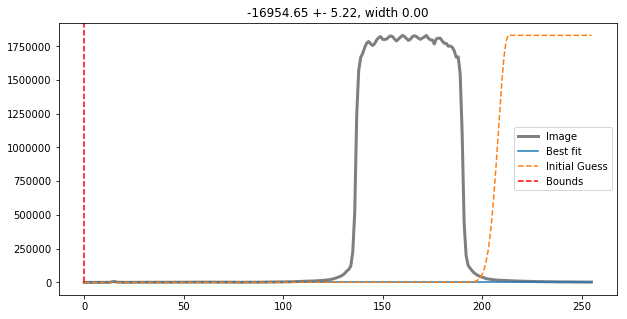

using a PHOENIX stellar model


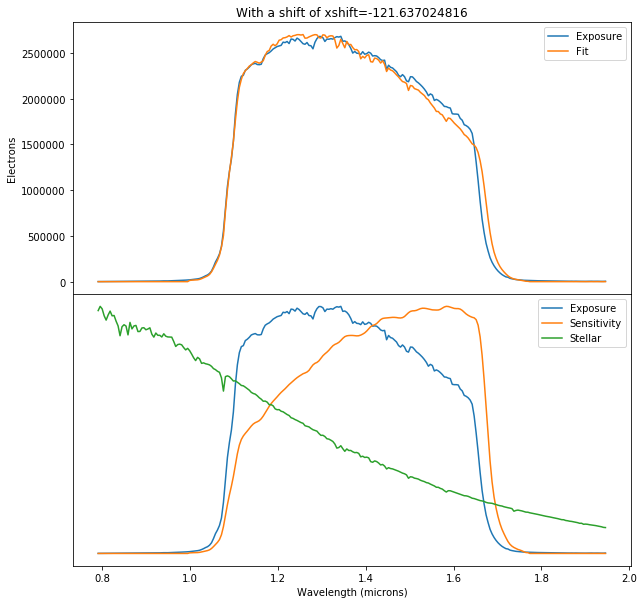

Applied an xshift of -121.637024816 pix compared to direct image
applying postarg offset to yguess, 147.60 pix


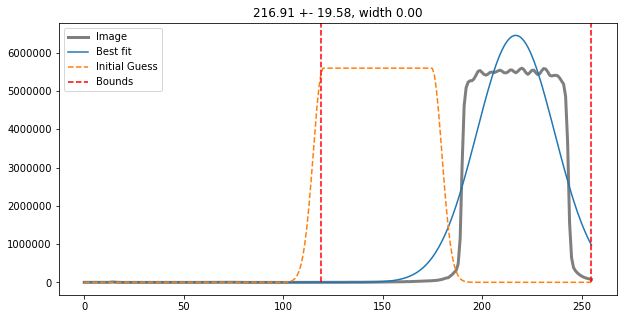

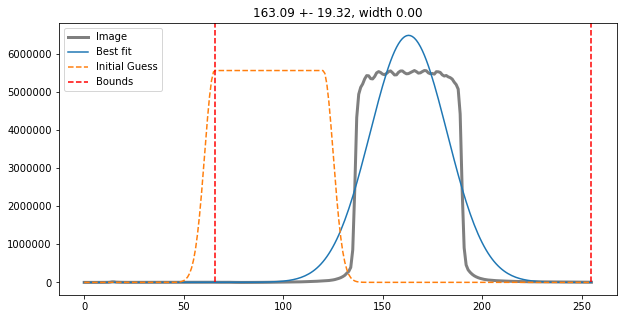

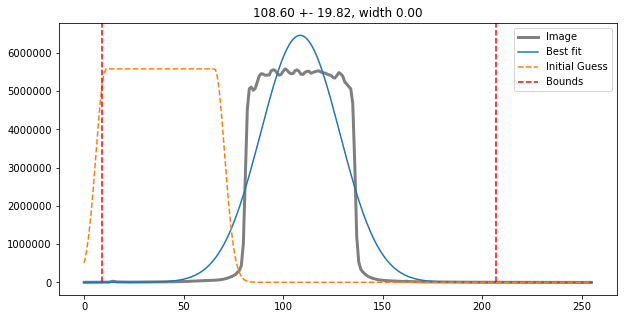

secondxpix 23.38999438478905 0.0
applying postarg offset to yguess, 147.60 pix


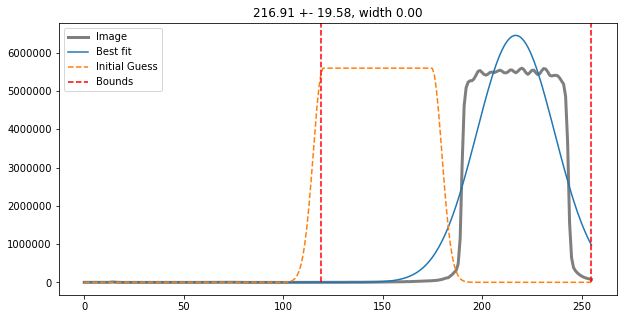

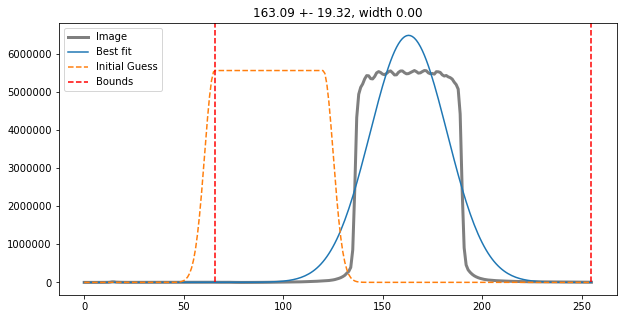

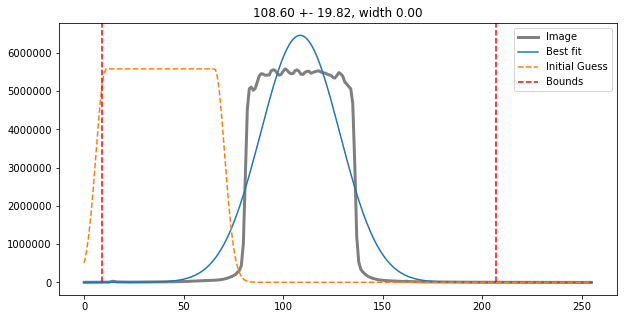

Saving reduced file to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/
Saving reduced exposure to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/ibh726meq_red.fits...
Reduction took 3.59s
########################################
###########Finished Reduction###########
########################################
########################################
###########Starting Extraction##########
########################################
Spectral extraction pipeline performed on exposure /Users/bob/Documents/PhD/hstscan/hstscan/example/Data/ibh726meq_ima.fits
For configuration, see conf file: /Users/bob/Documents/PhD/hstscan/hstscan/example/transmission_extraction.conf
Extracting from subexposure 1
Extracting spectrum with a 80 high extraction box
Spectrum located at pixel 123.389994385 in spatial direction
Using flux for variance estimate
Extracting spectrum with optimal extraction...


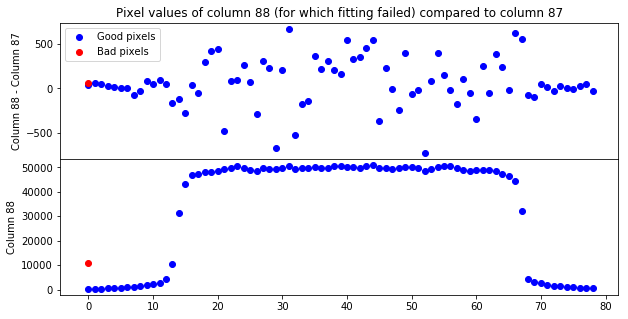

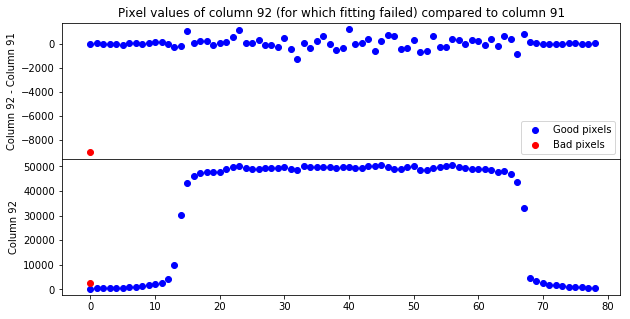

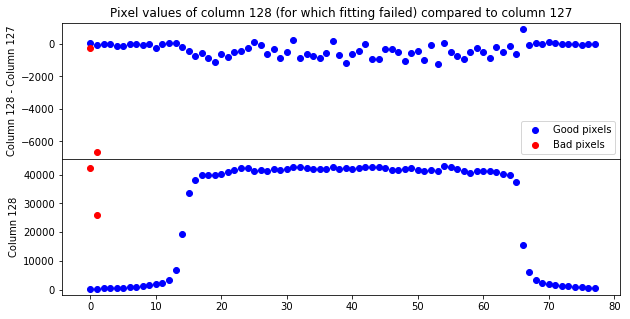

194 successes out of 200 total fits
Optimal extraction fitting failed for columns: [0, 1, 88, 92, 128, 198]
Clipped 0 cosmic rays in OE
Extracting from subexposure 2
Spectrum located at pixel 123.389994385 in spatial direction
Extracting spectrum with optimal extraction...


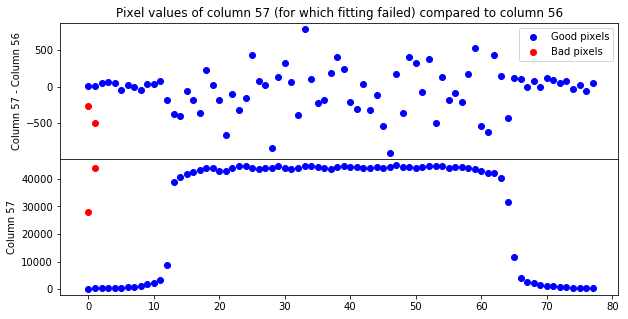

196 successes out of 200 total fits
Optimal extraction fitting failed for columns: [0, 1, 2, 57]
Clipped 0 cosmic rays in OE
Extracting from subexposure 3
Spectrum located at pixel 123.389994385 in spatial direction
Extracting spectrum with optimal extraction...


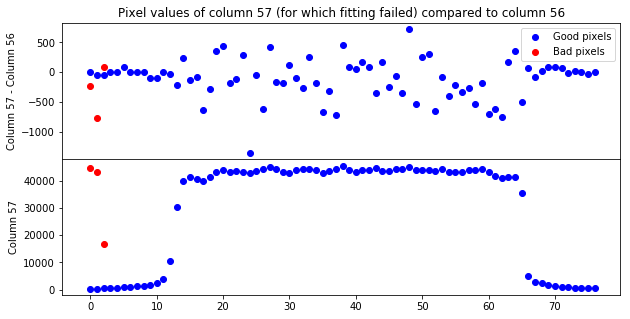

190 successes out of 200 total fits
Optimal extraction fitting failed for columns: [3, 5, 6, 7, 8, 57]
Clipped 0 cosmic rays in OE


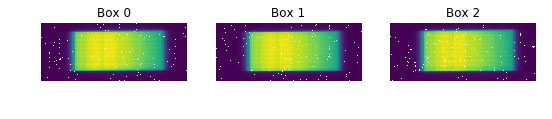

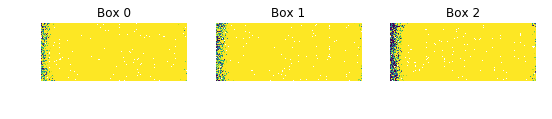

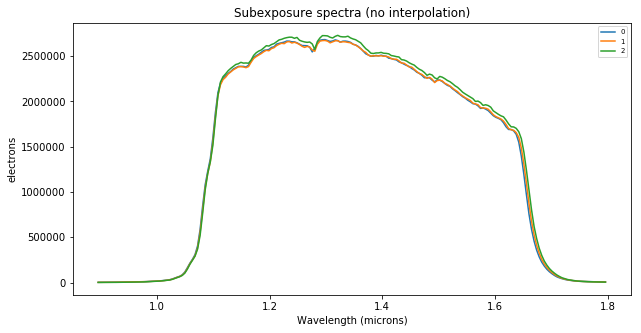

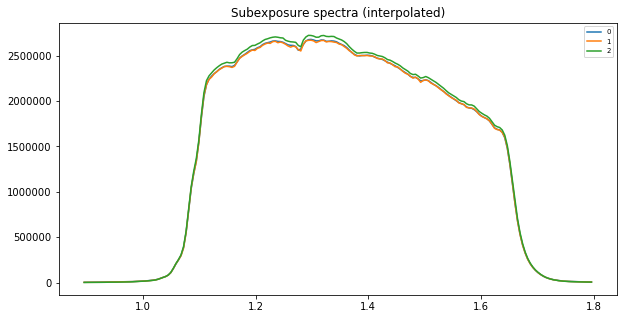

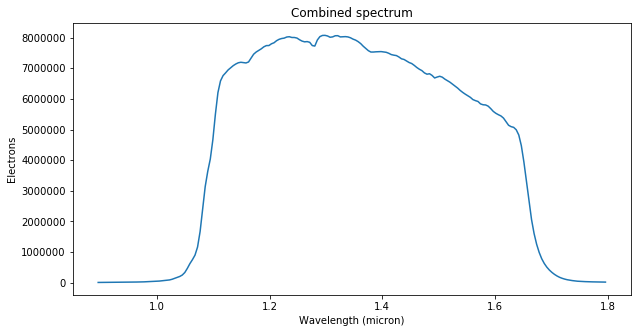

Saving spectrum to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/ibh726meq_spec.txt
Extraction took 1.72s
########################################
###########Finished Extraction##########
########################################


In [10]:
it = 0
for Image in ref_Images:
    visit = 1
    if visit == 1:
        Bg_x, Bg_y, Bg_w, Bg_h = (215, 5, 38, 30)
        Ref_exp = ref_Images[0].split('_ima.fits')[0]
    exp = pipe.reduce_exposure(Image, pdf=False, logger=False, debug=False,
                               skip_start=1, remove_scan=False,
                               bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                               tsiaras=False, exp_drift=False, sigma=6, cr_thresh=50,
                               xshift_ext=0., exp_shift=True, ref_exp = Ref_exp,
                               conf_file=conf_file_red, \
                               source_dir=data_dir)
    
    exp_spectrum, variance, interp_spectra, variances = \
                        pipe.extract_spectra(exp, pdf=False, logger=False, box_h=80,       
                        conf_file=conf_file_ext,
                        save_dir=output_dir)
    

In [11]:
%%capture

BGs0 = []
BGs2 = []
Ts  = []
reload(pipe)
it = 0
for Image in Images:
    visit = 1
    if visit == 1:
        Bg_x, Bg_y, Bg_w, Bg_h = (215, 5, 38, 30)
        Ref_exp = ref_Images[0].split('_ima.fits')[0]
    exp = pipe.reduce_exposure(Image, pdf=False, logger=False, debug=False,
                               skip_start=1, remove_scan=False,
                               bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                               tsiaras=False, exp_drift=False, sigma=6, cr_thresh=50,
                               xshift_ext=0., exp_shift=True, ref_exp = Ref_exp,
                               conf_file=conf_file_red, \
                               source_dir=data_dir)
    
    exp_spectrum, variance, interp_spectra, variances = \
                        pipe.extract_spectra(exp, pdf=False, logger=False, box_h=80,       
                        conf_file=conf_file_ext,
                        save_dir=output_dir)
    
    BGs0.append(exp.BGs[0][0,0])
    BGs2.append(exp.BGs[2][0,0])
    Ts.append(exp.t)
    it +=1
    

Text(0,0.5,'Pixel value')

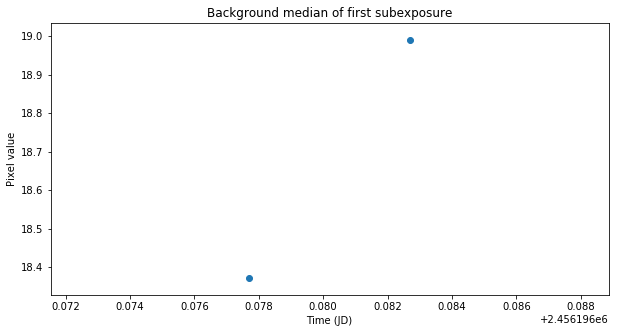

In [12]:
plt.title('Background median of first subexposure')
plt.scatter(Ts, BGs0)
plt.xlabel('Time (JD)')
plt.ylabel('Pixel value')

Text(0,0.5,'Pixel value')

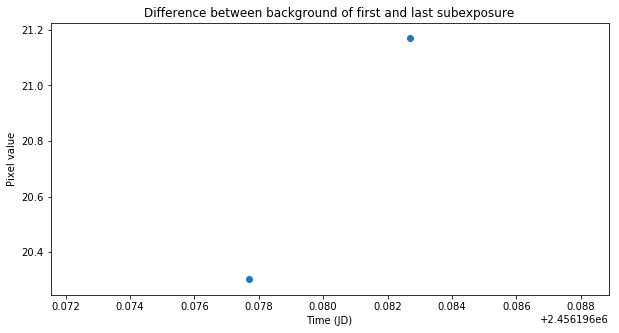

In [13]:
plt.scatter(Ts, np.array(BGs2) - np.array(BGs0))
plt.title('Difference between background of first and last subexposure')
plt.xlabel('Time (JD)')
plt.ylabel('Pixel value')